# **LEMUR Module 2: Learning PyTorch**

For this assignment we will do some transfer learning. We will showcase how we can use pre-existing models, add layers, freeze layers, modify layers, and how we can train models in PyTorch.


## Installing Libraries and Connecting to GPU


In [7]:
import argparse
import json
from PIL import Image
from tqdm import tqdm
import copy
import math
import pandas as pd
import numpy as np
import os
import random
import torch
from torch import nn
import torchvision

%matplotlib inline
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Check CUDA

Cuda allows us to get direct access to the GPU.

The following lines check if you are able to connect to your GPU, or if you are connected to the CPU. We want to be able to connect to the GPU to be able to move our data, models, and training to the GPU side to speedup the process.

In [62]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("Connected to CPU.")

Connected to CPU.


## Getting the model and its weights 

Below we can see the VGG16 network and all its layers. It has the features layers, as well as the classifier layers. We want to modify the classifier to output into values that we want to see. Currently it classifies images into 1000 different outputs, but these are not necessarily what we want.

In [3]:
from torchvision.models import vgg16, VGG16_Weights

vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [4]:
weights = VGG16_Weights.IMAGENET1K_V1
model = vgg16(weights=weights)

# Lets transfer the model to CUDA
if device == 'cuda':
    model = model.to('cuda')

## Dataset

Here we will learn how to use a few datasets, first lets look at CIFAR10 and how we can load it

In [49]:
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

data_tr = torchvision.datasets.CIFAR10(root='./data/',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(data_tr,
                                        batch_size=4,
                                        shuffle=True)

### YOUR CODE STARTS HERE ###
'''You need to create 2 different datasets, the test set and the validation set.'''
data_te = torchvision.datasets.CIFAR10(root='./data/',
                                      train=False,
                                      download=True,
                                      transform=transform)
testloader = torch.utils.data.DataLoader(data_te,
                                        batch_size=4,
                                        shuffle=False)

# I need to see how to make the validation and testing different here
data_va = torchvision.datasets.CIFAR10(root='./data/',
                                      train=False,
                                      download=True,
                                      transform=transform)
valloader = torch.utils.data.DataLoader(data_va,
                                        batch_size=4,
                                        shuffle=False)
### YOUR CODE ENDS HERE ###

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Lets check our data

You should be able to see images of dogs, planes, ships, and others.

You can run the following block multiple times to see different images for the training set, the test set should stay the same.

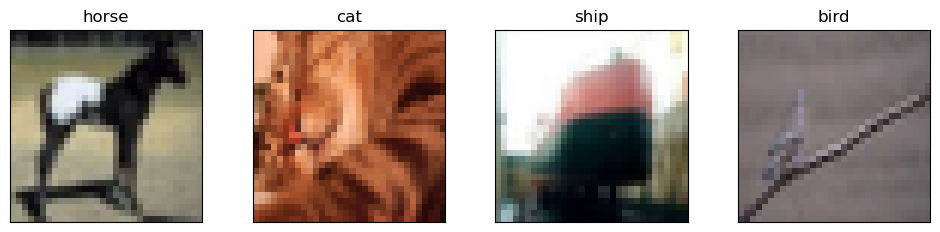

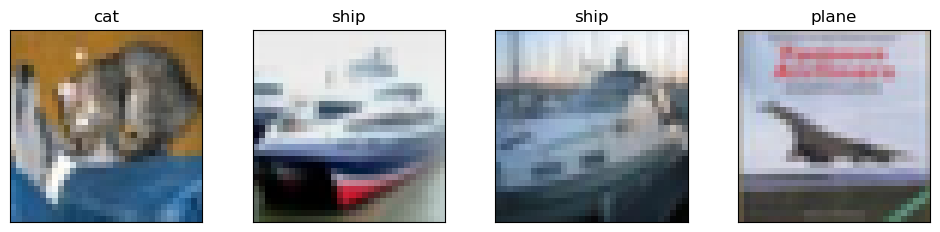

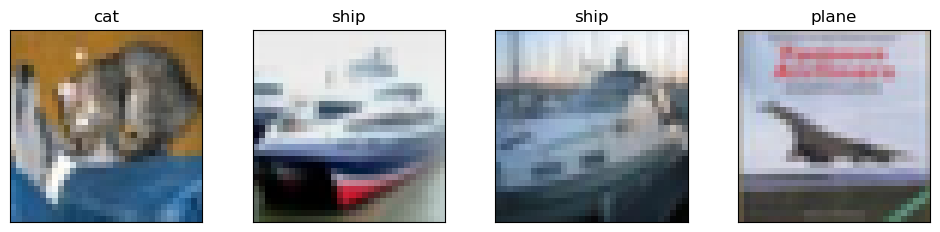

In [64]:
def to_imshow(img):
    # From [-1, 1] to [0, 1]
    img = img / 2 + 0.5
    img = img.numpy()
    return img.transpose(1,2,0)

dataiter = iter(trainloader)
images, labels = next(dataiter)

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, img in enumerate(images):
    axes[idx].imshow(to_imshow(img))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])
    
dataiter = iter(testloader)
images, labels = next(dataiter)

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, img in enumerate(images):
    axes[idx].imshow(to_imshow(img))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])
    
dataiter = iter(valloader)
images, labels = next(dataiter)

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, img in enumerate(images):
    axes[idx].imshow(to_imshow(img))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

## Creating the NN

This is here for now to showcase what a Deep Neural Network looks like and how to create it. For the module as a whole, I think we could see about creating your own NN as well as using the pretrained weights later to connect them a bit more.

In [51]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [52]:
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## Training the model

### We need to define a Loss function and Optimizer
What kind of a loss and optimizer do you want to use for this particular problem?

*Answer:*

In [53]:
import torch.optim as optim

### YOUR CODE STARTS HERE ### 
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
### YOUR CODE ENDS HERE ### 

### Now we need to train our created NN model, after which we can check the loss

Try running the following for loop with CUDA enabled and without, and see what the time difference is in training.

In [54]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        if device == 'cuda':
            data.to('cuda')

        ### YOUR CODE STARTS HERE ### 
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        ### YOUR CODE ENDS HERE ### 

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.170
[1,  4000] loss: 1.836
[1,  6000] loss: 1.654
[1,  8000] loss: 1.557
[1, 10000] loss: 1.505
[1, 12000] loss: 1.466
[2,  2000] loss: 1.386
[2,  4000] loss: 1.375
[2,  6000] loss: 1.317
[2,  8000] loss: 1.320
[2, 10000] loss: 1.296
[2, 12000] loss: 1.261
Finished Training


## Saving the model

Now that we have trained the model, we also need to save it to be able to use it again in the future.

In [55]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

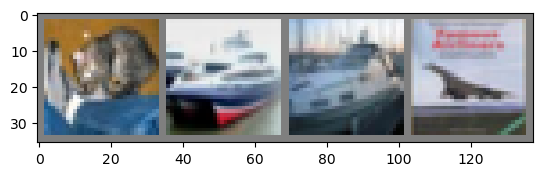

GroundTruth:  cat   ship  ship  plane


In [56]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [57]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [58]:
outputs = net(images)

In [59]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  ship 


In [60]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 56 %


In [61]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 65.3 %
Accuracy for class: car   is 70.4 %
Accuracy for class: bird  is 50.8 %
Accuracy for class: cat   is 33.5 %
Accuracy for class: deer  is 32.8 %
Accuracy for class: dog   is 55.4 %
Accuracy for class: frog  is 67.0 %
Accuracy for class: horse is 59.7 %
Accuracy for class: ship  is 73.3 %
Accuracy for class: truck is 61.1 %


## Transfer Learning
### Lets do the same as we did above, but this time we have a pre-trained model

In [36]:
# First lets freeze most layers
c = 0

for param in model.features.parameters():
    c += 1
    if c < 22:
        param.requires_grad = False
    else:
        param.requires_grad = True
        
for param in model.features.parameters():
    print(param.requires_grad)
        
    
print(model)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 

In [43]:
# Run only once
model.classifier[6] = nn.Linear(4096, 10) 
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [44]:
def train(model, training_loader, num_epochs=1):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    criterion = nn.MSELoss()
    if device == 'cuda':
        model.to('cuda')
    
    for epoch in range(0, num_epochs):
        print("Epoch {}/{}".format(epoch + 1, num_epochs))
        for phase in ['train']:
            if phase == 'train':
                model.train()
            else:
                model.eval()   
            running_loss = 0.

            # Here, we use enumerate(training_loader) instead of
            # iter(training_loader) so that we can track the batch
            # index and do some intra-epoch reporting
            for i, data in enumerate(training_loader):
                # Every data instance is an input + label pair
                inputs, labels = data
                labels = labels.float()
                if device == 'cuda':
                    inputs, labels = inputs.to('cuda'), labels.to('cuda')

                # Zeroing the gradients
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase=='train'):
                    
                    # Make predictions for this batch
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = torch.sqrt(criterion(outputs.squeeze(), labels.squeeze()))
                    
                    # Compute the loss and its gradients
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                    running_loss += loss.item()
           
                
            epoch_loss = running_loss/len(training_loader)
            
            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            
    return model

In [45]:
dataloaders = {
    'train': trainloader,
    'val': valloader,
    'test': testloader
}

In [46]:
# Now we train the model
model_trained = train(model, dataloaders['train'], 6)

Epoch 1/6


KeyboardInterrupt: 

In [ ]:
def evaluate(model, eval_loader):
    criterion = nn.MSELoss()
    
    model.eval()   
    running_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(eval_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        labels = labels.float()
        if device == 'cuda':
        `inputs, labels = inputs.to('cuda'), labels.to('cuda')

        with torch.set_grad_enabled(False):

            # Make predictions for this batch
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = torch.sqrt(criterion(outputs.squeeze(), labels.squeeze()))

            running_loss += loss.item()


    epoch_loss = running_loss/len(eval_loader)

    print('Loss: {:.4f}'.format(epoch_loss))

In [ ]:
evaluate(model_trained, dataloaders['val'])

In [ ]:
evaluate(model_trained, dataloaders['test'])

## Saving the model

Now that we have trained the model, we also need to save it to be able to use it again in the future.